## Import Libraries

In [553]:
import time
import rospy
import numpy as np
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from dual_quaternion import Quaternion
from dual_quaternion import DualQuaternion
from casadi import Function
from dual_quaternion import plot_states_quaternion, plot_states_position, fancy_plots_4, fancy_plots_1, plot_norm_quat, plot_angular_velocities, plot_linear_velocities, fancy_plots_3, plot_norm_real, plot_norm_dual


## Working with Symbolic Variables

In [554]:
# Defining Mobile Robot Frame
qw_1 = ca.MX.sym('qw_1', 1, 1)
qx_1 = ca.MX.sym('qx_1', 1, 1)
qy_1 = ca.MX.sym('qy_1', 1, 1)
qz_1 = ca.MX.sym('qz_1', 1, 1)
q_1 = ca.vertcat(qw_1, qx_1, qy_1, qz_1)
dw_1 = ca.MX.sym("dw_1", 1, 1)
dx_1 = ca.MX.sym("dx_1", 1, 1)
dy_1 = ca.MX.sym("dy_1", 1, 1)
dz_1 = ca.MX.sym("dz_1", 1, 1)
d_1 = ca.vertcat(dw_1, dx_1, dy_1, dz_1)


aux_symbolic_total = ca.vertcat(qw_1, qx_1, qy_1, qz_1, dw_1, dx_1, dy_1, dz_1)
symbolic_actions = ca.vertcat(qw_1, qx_1, qy_1, qz_1, dw_1,dx_1, dy_1, dz_1)
dual_1_data = ca.vertcat(qw_1, qx_1, qy_1, qz_1, dw_1,dx_1, dy_1, dz_1)

In [555]:
theta_1_aux = ca.MX.sym('theta_1_aux', 1, 1)
n_1_aux = ca.MX([0.0, 0.0, 1.0])
q_1_aux = ca.vertcat(ca.cos(theta_1_aux/2), ca.sin(theta_1_aux/2)@n_1_aux)
tx_1_aux = ca.MX.sym("tx_1_aux", 1, 1)
ty_1_aux = ca.MX.sym("ty_1_aux", 1, 1)
t_1_aux = ca.vertcat(0.0, tx_1_aux, ty_1_aux, 0.0)
aux_symbolic_total_aux = ca.vertcat(theta_1_aux, tx_1_aux, ty_1_aux)

In [556]:
# Defining Desired Frame
qw_1d = ca.MX.sym('qw_1d', 1, 1)
qx_1d = ca.MX.sym('qx_1d', 1, 1)
qy_1d = ca.MX.sym('qy_1d', 1, 1)
qz_1d = ca.MX.sym('qz_1d', 1, 1)

q_1d = ca.vertcat(qw_1d, qx_1d, qy_1d, qz_1d)

dw_1d = ca.MX.sym("dw_1d", 1, 1)
dx_1d = ca.MX.sym("dx_1d", 1, 1)
dy_1d = ca.MX.sym("dy_1d", 1, 1)
dz_1d = ca.MX.sym("dz_1d", 1, 1)

d_1d = ca.vertcat(dw_1d, dx_1d, dy_1d, dz_1d)


dual_1d_data = ca.vertcat(qw_1d, qx_1d, qy_1d, qz_1d, dw_1d, dx_1d, dy_1d, dz_1d)

# Defining the desired Velocity
vx_1d = ca.MX.sym("vx_1d", 1, 1)
vy_1d = ca.MX.sym("vy_1d", 1, 1)
vz_1d = ca.MX.sym("vz_1d", 1, 1)

wx_1d = ca.MX.sym("wx_1d", 1, 1)
wy_1d = ca.MX.sym("wy_1d", 1, 1)
wz_1d = ca.MX.sym("wz_1d", 1, 1)

Vd = ca.vertcat(0.0, vx_1d, vy_1d, vz_1d)
Wd = ca.vertcat(0.0, wx_1d, wy_1d, wz_1d)

w_1d_data = ca.vertcat(wx_1d, wy_1d, wz_1d, vx_1d, vy_1d, vz_1d)

## Control Gains

In [557]:
# Defining the desired Velocity
kr1 = ca.MX.sym("kr1", 1, 1)
kr2 = ca.MX.sym("kr2", 1, 1)
kr3 = ca.MX.sym("kr3", 1, 1)

kd1 = ca.MX.sym("kd1", 1, 1)
kd2 = ca.MX.sym("kd2", 1, 1)
kd3 = ca.MX.sym("kd3", 1, 1)


Kr = ca.vertcat(0.0, kr1, kr2, kr3)
Kd = ca.vertcat(0.0, kd1, kd2, kd3)

k_data = ca.vertcat(kr1, kr2, kr3, kd1, kd2, kd3)

ts = ca.MX.sym("ts", 1, 1)


### Computing Sequential Transformations

In [558]:
Q1 = DualQuaternion(q_real= Quaternion(q = q_1), q_dual = Quaternion(q = d_1))
Q1

DualQuaternion(Qr=Quaternion: vertcat(qw_1, qx_1, qy_1, qz_1), Qd=Quaternion: vertcat(dw_1, dx_1, dy_1, dz_1))

In [559]:
Q1d = DualQuaternion(q_real= Quaternion(q = q_1d), q_dual = Quaternion(q = d_1d))
Q1d

DualQuaternion(Qr=Quaternion: vertcat(qw_1d, qx_1d, qy_1d, qz_1d), Qd=Quaternion: vertcat(dw_1d, dx_1d, dy_1d, dz_1d))

In [560]:
W1d = DualQuaternion(q_real= Quaternion(q = Wd), q_dual= Quaternion(q= Vd))
W1d

DualQuaternion(Qr=Quaternion: vertcat(0, wx_1d, wy_1d, wz_1d), Qd=Quaternion: vertcat(0, vx_1d, vy_1d, vz_1d))

In [561]:
Kp =  DualQuaternion(q_real= Quaternion(q = Kr), q_dual= Quaternion(q= Kd))
Kp

DualQuaternion(Qr=Quaternion: vertcat(0, kr1, kr2, kr3), Qd=Quaternion: vertcat(0, kd1, kd2, kd3))

In [562]:
Q1_pose =  DualQuaternion.from_pose(quat = q_1_aux, trans = t_1_aux)
Q1_pose.get_dual.get[:,0]

MX((0.5*mac(horzcat(horzcat(0, (-tx_1_aux), (-ty_1_aux), 0)', horzcat(tx_1_aux, 0, 0, ty_1_aux)', horzcat(ty_1_aux, 0, 0, (-tx_1_aux))', horzcat(0, (-ty_1_aux), tx_1_aux, 0)')',vertcat(cos((theta_1_aux/2)), ([0, 0, 1]*sin((theta_1_aux/2)))),zeros(4x1))))

## Generating Function Using CasADi

In [563]:
Function_DualQuat_total = Function('DualQuat_total', [aux_symbolic_total], [Q1.get[:, 0]])
Function_DualQuat_total_trans = Function('DualQuat_total_trans', [aux_symbolic_total], [Q1.get_trans.get[:, 0]])
Function_DualQuat_total_quat = Function('DualQuat_total_quat', [aux_symbolic_total], [Q1.get_quat.get[:, 0]])
Function_DualQuat_pose = Function('DualQuat_pose', [theta_1_aux, tx_1_aux, ty_1_aux], [Q1_pose.get[:, 0]])


## Using Functions

In [564]:
theta1 = -np.pi/2
tx1 = -5.0
ty1 = 2.0

dual_1_pose = Function_DualQuat_pose(theta1, tx1, ty1)
dual = Function_DualQuat_total(dual_1_pose)
dual_trans = Function_DualQuat_total_trans(dual)
dual_quat = Function_DualQuat_total_quat(dual)

print(dual_1_pose)
print(dual_trans)
#dual

[0.707107, -0, -0, -0.707107, 0, -2.47487, -1.06066, 0]
[0, -5, 2, 0]


In [565]:
# Compute short path to the desired quaternion
q_error = ca.MX.sym('q_error', 8, 1)

# Define the function
f_error = ca.Function('f_error', [q_error], [ca.if_else(q_error[0, 0] >= 0, q_error, -q_error)])

In [566]:
aux = np.array([-2.0, 1.0, 0.0, -3, 5, -1, 8, 0])
print(aux)

aux = f_error(aux)
print(aux)

[-2.  1.  0. -3.  5. -1.  8.  0.]
[2, -1, 0, 3, -5, 1, -8, 0]


In [567]:
def dual_velocity_f(W, dual, W_data, dual_data):
    w = W.get_real
    v = W.get_dual
    p = dual.get_trans

    real = w
    dual = v + p.cross(w)
    
    dual_velocity = DualQuaternion(q_real = real, q_dual = dual)
    aux = dual_velocity.get[:, 0]
    velocity = ca.vertcat(aux[1, 0], aux[2, 0], aux[3, 0], aux[5, 0], aux[6, 0], aux[7, 0])
    f_velocity = Function('f_velocity', [W_data, dual_data], [velocity])
    return f_velocity

## Computing Control Law

In [568]:
def dual_control(qd, wd, q, kp, qd_data, wd_data, q_data, kp_data):
    q_e = q * qd.conjugate()
    
    q_error = f_error(q_e.get[:, 0])

    q_e = DualQuaternion(q_real=Quaternion(q = q_error[0:4, 0]), q_dual= Quaternion(q = q_error[4:8, 0]))
    # Apply log mapping
    q_e_ln = q_e.ln_control()

    # Conjugate
    q_e_c = q_e.conjugate()

    # Control Law 
    U = -2*q_e_ln.vector_dot_product(kp) + q_e * wd * q_e_c
    aux = U.get[:, 0]
    control_values = ca.vertcat(aux[1, 0], aux[2, 0], aux[3, 0], aux[5, 0], aux[6, 0], aux[7, 0])

    f_control = Function('f_control', [qd_data, wd_data, q_data, kp_data], [control_values])
    return f_control

## Generating functions based on CasADi

In [569]:
control_law = dual_control(Q1d, W1d, Q1, Kp, dual_1d_data, w_1d_data, dual_1_data, k_data)
dual_velocity = dual_velocity_f(W1d, Q1d, w_1d_data, dual_1d_data)

## Verifying Functions

In [570]:
theta1 = -np.pi/2
tx1 = -5.0
ty1 = 2.0
dual_1_pose = Function_DualQuat_pose(theta1, tx1, ty1)
dual_1 = Function_DualQuat_total(dual_1_pose)


theta1d = np.pi/2
tx1d = 2.0
ty1d = -2.0
dual_1d_pose = Function_DualQuat_pose(theta1d, tx1d, ty1d)
dual_1d = Function_DualQuat_total(dual_1d_pose)


w_d = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
kp = np.array([2.0, 2.0, 2.0, 2.0, 2.0, 2.0])

w_dual = dual_velocity(w_d, dual_1d)
control = control_law(dual_1d_pose, w_dual, dual_1_pose, kp)
control

DM([0, 0, 3.14159, 6, -1.77636e-15, 0])

## Runge Kuta 4

In [571]:
def quatdot(quat, omega):
    quat_data = quat.get_real
    dual_data =  quat.get_dual

    # Auxiliary variable in order to avoid numerical issues
    norm_r, norm_d = quat.norm_dual
    K_quat = 2
    quat_error = 1 - norm_r
    dual_error = norm_d

    aux_1 = quat_data * (K_quat*quat_error)
    aux_2 = dual_data * (K_quat*dual_error)

    aux_dual = DualQuaternion(q_real = aux_1, q_dual = aux_2)

    #q_dot = (1/2)*(omega * quat) + aux_dual
    q_dot = (1/2)*(omega * quat)
    return q_dot

def f_rk4_c(quat, omega, ts, quat_data, omega_data, ts_data):
    # Function that computes 
    k1 = quatdot(quat, omega)
    k2 = quatdot(quat + (1/2)*k1*ts, omega)
    k3 = quatdot(quat + (1/2)*k2*ts, omega)
    k4 = quatdot(quat + (1)*k3*ts, omega)
    # Compute forward Euler method
    quat = quat + (1/6)*(k1 + 2*k2 + 2*k3 + k4)*ts
    f_rk4 = Function('f_rk4', [quat_data, omega_data, ts_data], [quat.get[:, 0]])
    return f_rk4

In [572]:
f_rk4 = f_rk4_c(Q1d, W1d, ts, dual_1d_data, w_1d_data, ts)
f_rk4

Function(f_rk4:(i0[8],i1[6],i2)->(o0[8]) MXFunction)

### Simulation

In [573]:
sample_time = 0.01
t_f = 20

# Time defintion aux variable
t = np.arange(0, t_f + sample_time, sample_time)

# Initial DualQuaternion
theta1 = np.pi/2
tx1 = 2.0
ty1 = -2.0
dual_1_pose = Function_DualQuat_pose(theta1, tx1, ty1)
dual_1 = Function_DualQuat_total(dual_1_pose)


# Desired Dual Quaternion
theta1d = -np.pi/2
tx1d = -5.0
ty1d = 2.0
dual_1d_pose = Function_DualQuat_pose(theta1d, tx1d, ty1d)
dual_1d = Function_DualQuat_total(dual_1d_pose)

# Desired Velociy
w_1d = np.array([0.0, 0.0, 0.5, 0.1, 0.0, 0.0])
kp = np.array([2.0, 2.0, 2.0, 2.0, 2.0, 2.0]) 

# Data matrices
Q1_data = np.zeros((8, t.shape[0] + 1), dtype=np.double)
aux_quat_1 = np.array(Function_DualQuat_total_quat(dual_1))
aux_trans_1 = np.array(Function_DualQuat_total_trans(dual_1))

Q1_data[0:4, 0] = aux_quat_1.reshape((4, ))
Q1_data[4:8, 0] = aux_trans_1.reshape((4, ))

Q1d_data = np.zeros((8, t.shape[0] + 1), dtype=np.double)
aux_quat_1d = np.array(Function_DualQuat_total_quat(dual_1d))
aux_trans_1d = np.array(Function_DualQuat_total_trans(dual_1d))

Q1d_data[0:4, 0] = aux_quat_1d.reshape((4, ))
Q1d_data[4:8, 0] = aux_trans_1d.reshape((4, ))

for k in range(0, t.shape[0]):
    # Reference Dual Quaternion
    w1d_dual = dual_velocity(w_1d, dual_1d)
    dual_1d = f_rk4(dual_1d, w1d_dual, sample_time)

    # Control Law
    control_values = control_law(dual_1d, w1d_dual, dual_1, kp)

    # Evolution fo the system
    dual_1 = f_rk4(dual_1, control_values, sample_time)

    # Save information
    aux_quat_1 = np.array(Function_DualQuat_total_quat(dual_1))
    aux_trans_1 = np.array(Function_DualQuat_total_trans(dual_1))

    Q1_data[0:4, k+1] = aux_quat_1.reshape((4, ))
    Q1_data[4:8, k+1] = aux_trans_1.reshape((4, ))

    aux_quat_1d = np.array(Function_DualQuat_total_quat(dual_1d))
    aux_trans_1d = np.array(Function_DualQuat_total_trans(dual_1d))

    Q1d_data[0:4, k+1] = aux_quat_1d.reshape((4, ))
    Q1d_data[4:8, k+1] = aux_trans_1d.reshape((4, ))

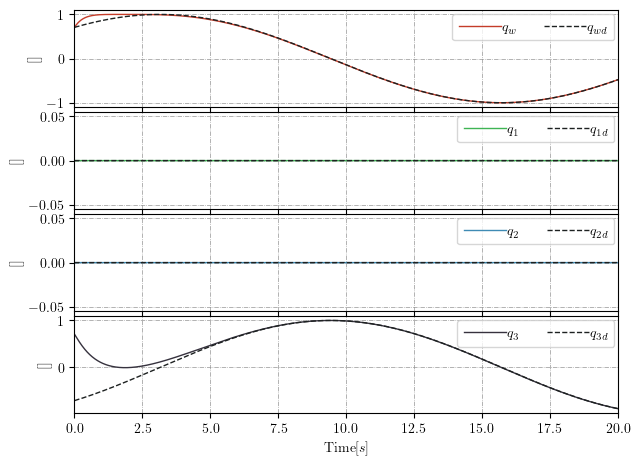

In [574]:
# PLot Results
fig11, ax11, ax21, ax31, ax41 = fancy_plots_4()
plot_states_quaternion(fig11, ax11, ax21, ax31, ax41, Q1_data[0:4, :], Q1d_data[0:4, :], t, "Quaternions Results")
plt.show()


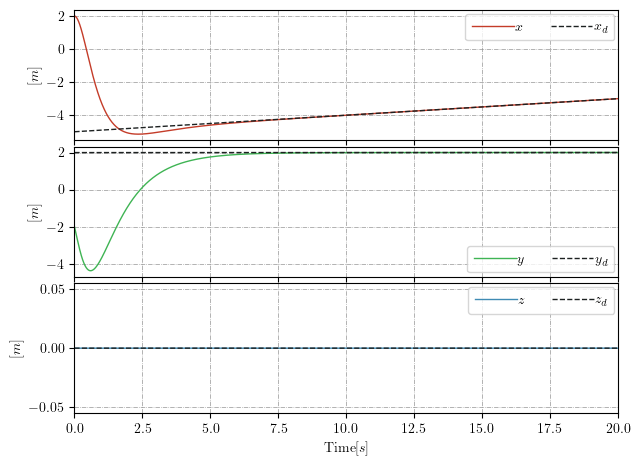

In [575]:
fig12, ax12, ax22, ax32 = fancy_plots_3()
plot_states_position(fig12, ax12, ax22, ax32, Q1_data[5:8, :], Q1d_data[5:8, :], t, "Position of the System")
plt.show()